

# 🎯 Mini-compétition – Adult Income (Starter Notebook)

**Objectif :** construire un pipeline de machine learning pour prédire la probabilité que `income == 1` (revenu > 50K$).  
**Livrables :** ce notebook (complété) + `submission.csv` au format `id,income_prob`.

> Conseils : travaillez par itérations courtes ; validez vos idées par CV ; consignez clairement vos choix (Markdown).


## 1) Importations et configuration
- Utilisez `pandas`, `numpy`, `scikit-learn`.
- La métrique principale est **ROC AUC** (tiebreaker : Log Loss).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_regression
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.model_selection import (StratifiedKFold, cross_val_score,
                                     train_test_split, GridSearchCV)
from sklearn.metrics import (roc_auc_score, log_loss, classification_report,
                             confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer

# Algorithmes
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,
                              GradientBoostingClassifier, ExtraTreesClassifier,
                              StackingClassifier)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Gestion du déséquilibre
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Statistiques
from scipy.stats import skew

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Configuration graphiques
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

data_dir = Path(".")
print("="*50)
print("🚀 ADULT INCOME PREDICTION - MINI-COMPÉTITION")
print("="*50)
print(f"Version libs – pandas: {pd.__version__}")
print(f"Random State: {RANDOM_STATE}")
print("Configuration terminée ✅. \n")

🚀 ADULT INCOME PREDICTION - MINI-COMPÉTITION
Version libs – pandas: 2.2.2
Random State: 42
Configuration terminée ✅. 



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



## 2) Chargement des données

Assurez-vous d'avoir **train.csv** et **test.csv** dans le même dossier que ce notebook.  
- `train.csv` contient la colonne cible `income` (0/1)  
- `test.csv` ne contient **pas** la colonne `income`, mais possède une colonne `id`


In [ ]:
print("="*80)
print(" CHARGEMENT DES DONNÉES")
print("="*80)

train = pd.read_csv("/content/drive/MyDrive/Bri_Mini_compétition/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Bri_Mini_compétition/test.csv")


print("train shape:", train.shape)
print("test  shape:", test.shape)
train.head()

 CHARGEMENT DES DONNÉES
train shape: (39073, 16)
test  shape: (9769, 16)


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,class,income
0,71,Private,77253,HS-grad,9,Never-married,Handlers-cleaners,Not-in-family,White,Male,0,0,17,United-States,<=50K,0
1,17,Private,329783,10th,6,Never-married,Sales,Other-relative,White,Female,0,0,10,United-States,<=50K,0
2,27,Private,91257,HS-grad,9,Married-civ-spouse,Other-service,Husband,White,Male,0,0,40,El-Salvador,<=50K,0
3,43,Private,125577,HS-grad,9,Separated,Adm-clerical,Unmarried,Black,Female,0,0,40,United-States,<=50K,0
4,31,Private,137978,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,<=50K,0


###  Pré-nettoyage


## 3) EDA rapide (à compléter)
- Vérifiez les types, valeurs manquantes, cardinalité des catégorielles
- Affichez la distribution de `income`
- Identifiez les features numériques vs catégorielles



EDA - ANALYSE EXPLORATOIRE DES DONNÉES

1) Types de données:
age                int64
workclass         object
fnlwgt             int64
education         object
education_num      int64
marital_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain       int64
capital_loss       int64
hours_per_week     int64
native_country    object
class             object
income             int64
dtype: object

2) Informations générales:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39073 entries, 0 to 39072
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             39073 non-null  int64 
 1   workclass       36849 non-null  object
 2   fnlwgt          39073 non-null  int64 
 3   education       39073 non-null  object
 4   education_num   39073 non-null  int64 
 5   marital_status  39073 non-null  object
 6   occupation      36839 non-null

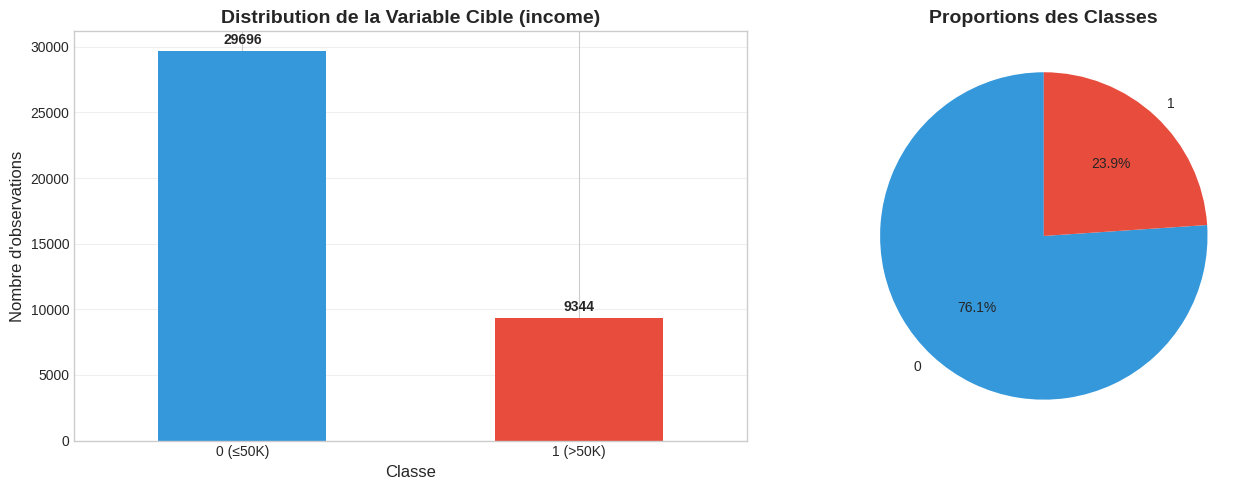

   ✅ Graphique sauvegardé : 01_target_distribution.png

9) Statistiques descriptives des variables numériques :
                  count         mean          std   min   25%   50%   75%  \
age             39040.0    38.704329    13.740137  17.0  28.0  37.0  48.0   
education_num   39040.0    10.079816     2.573031   1.0   9.0  10.0  12.0   
capital_gain    39040.0  1058.362474  7335.538331   0.0   0.0   0.0   0.0   
capital_loss    39040.0    90.028304   408.788113   0.0   0.0   0.0   0.0   
hours_per_week  39040.0    40.458504    12.417988   1.0  40.0  40.0  45.0   

                    max  
age                90.0  
education_num      16.0  
capital_gain    99999.0  
capital_loss     4356.0  
hours_per_week     99.0  

10) Visualisation des distributions numériques...


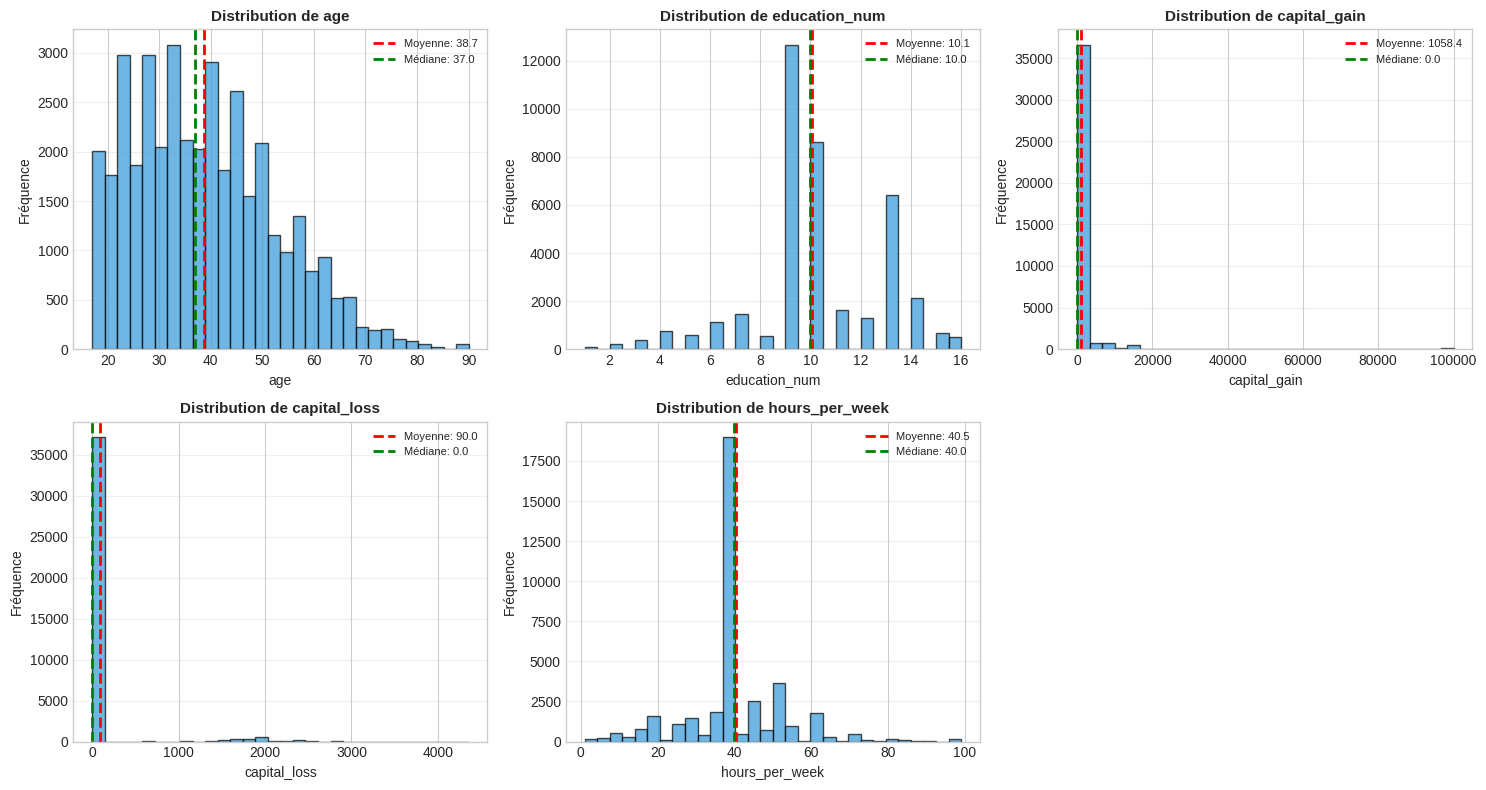

   ✅ Graphique sauvegardé : 02_numerical_distributions.png

11) Cardinalité des variables catégorielles :
   - workclass            :   8 modalités
   - marital_status       :   7 modalités
   - occupation           :  14 modalités
   - relationship         :   6 modalités
   - race                 :   5 modalités
   - sex                  :   2 modalités
   - native_country       :  41 modalités

12) Top 5 modalités par variable catégorielle :

   workclass:
workclass
Private             27078
Self-emp-not-inc     3062
Local-gov            2552
State-gov            1578
Self-emp-inc         1373
Name: count, dtype: int64

   marital_status:
marital_status
Married-civ-spouse    17831
Never-married         12911
Divorced               5306
Separated              1238
Widowed                1221
Name: count, dtype: int64

   occupation:
occupation
Prof-specialty     4940
Craft-repair       4900
Exec-managerial    4891
Adm-clerical       4492
Sales              4417
Name: count, dtype: in

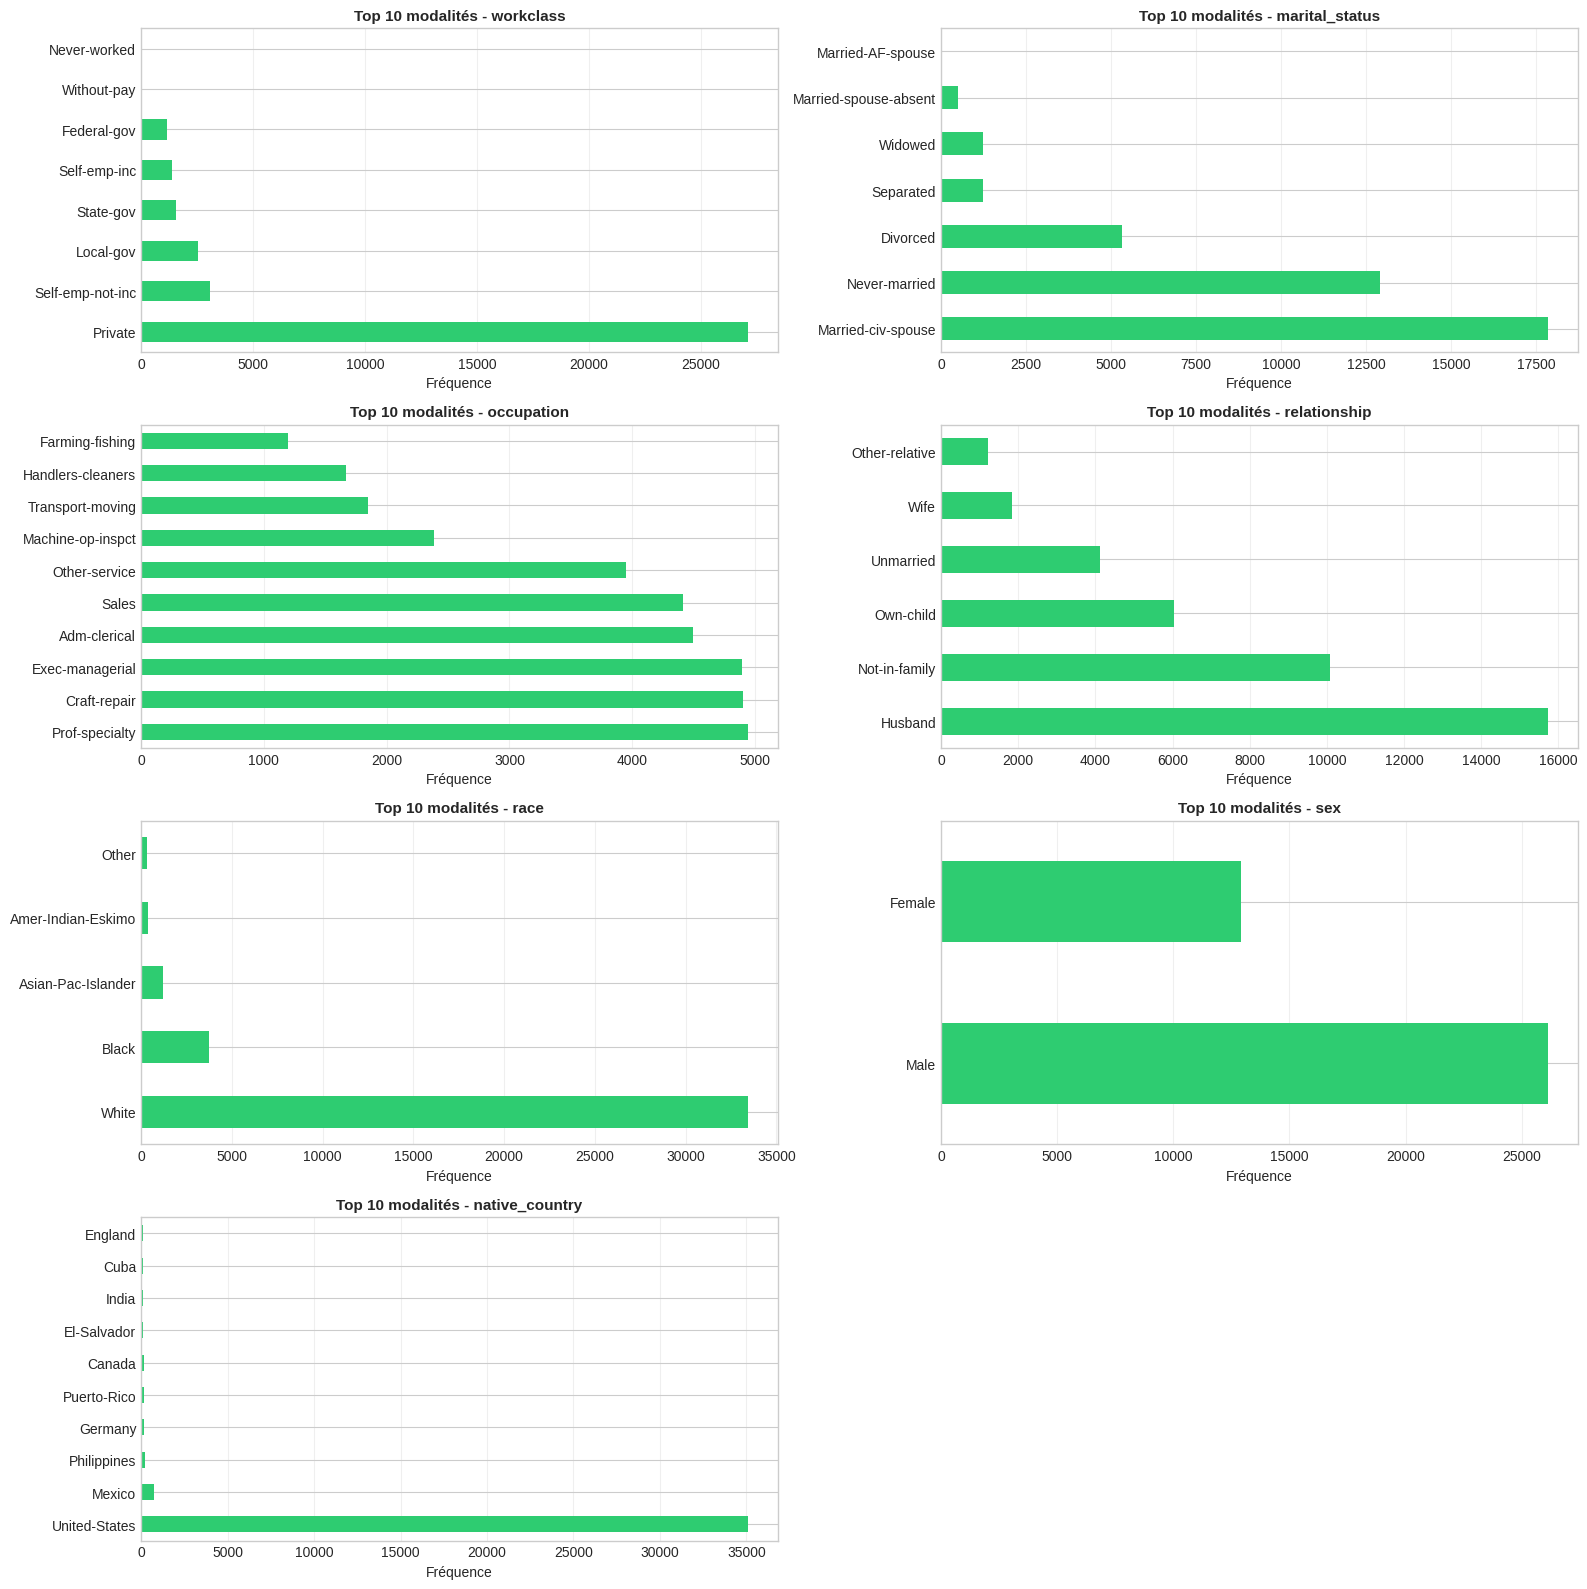

   ✅ Graphique sauvegardé : 03_categorical_distributions.png

14) Analyse de l'asymétrie (Skewness) :

   Skewness par variable :
capital_gain      12.042119
capital_loss       4.494827
age                0.549500
hours_per_week     0.251517
education_num     -0.312107
dtype: float64

   💡 Interprétation :
      |skew| < 0.5  : Distribution relativement symétrique
      0.5 < |skew| < 1.0 : Asymétrie modérée
      |skew| > 1.0  : Asymétrie forte → transformation log recommandée

   Variables avec forte asymétrie (|skew| > 1) : ['capital_gain', 'capital_loss']

15) Visualisation des variables asymétriques (avant/après log)...


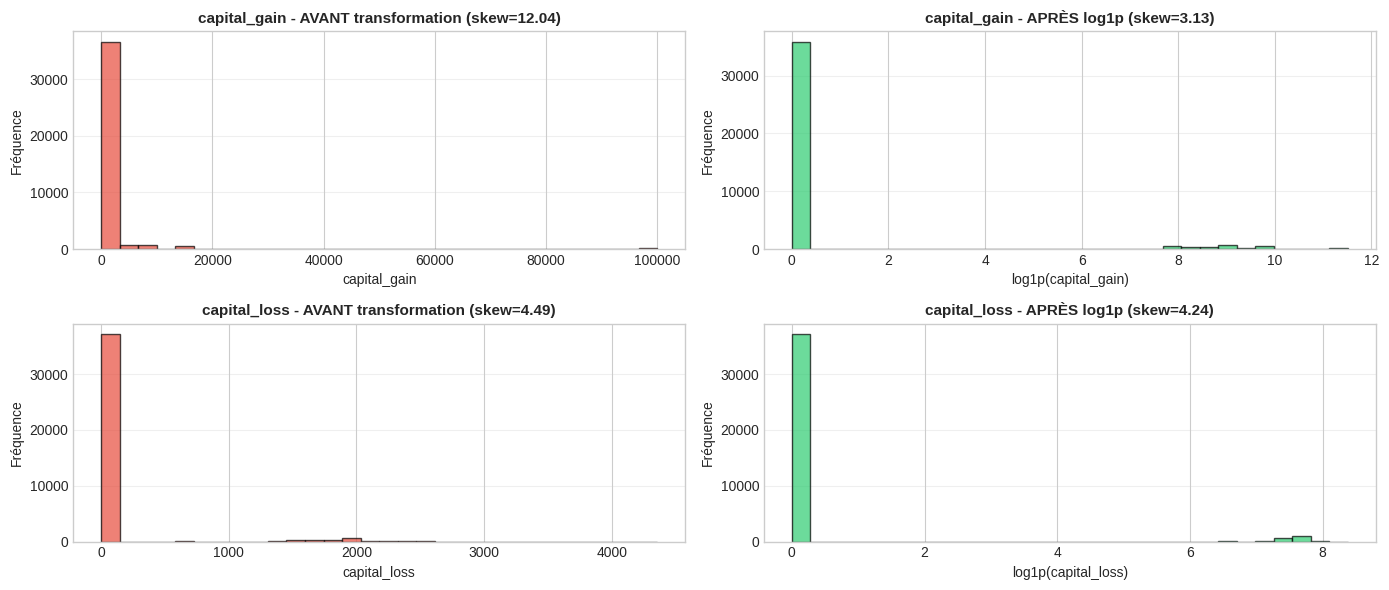

   ✅ Graphique sauvegardé : 04_skewness_correction.png

✅ EDA terminée - Insights principaux :
   1. Déséquilibre modéré (3.2:1) → SMOTE nécessaire
   2. Variables asymétriques détectées → transformation log
   3. Doublons supprimés : 33
   4. Features finales : 12 (après suppression colonnes redondantes)


In [ ]:

print("\n" + "="*80)
print("EDA - ANALYSE EXPLORATOIRE DES DONNÉES")
print("="*80)

# Types & aperçu
print("\n1) Types de données:")
print(train.dtypes)

print("\n2) Informations générales:")
print(train.info())

print("\n3) Statistiques descriptives (variables numériques):")
print(train.describe())

print("\n4) Valeurs manquantes (train):")
missing = train.isna().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
    print(f"\n   Taux de valeurs manquantes par variable:")
    for col in missing[missing > 0].index:
        pct = (missing[col] / len(train)) * 100
        print(f"   - {col}: {missing[col]} ({pct:.2f}%)")
else:
    print("✅ Aucune valeur manquante")

# Vérifier doublons
duplicates = train.duplicated().sum()
print(f"\n5) Doublons détectés : {duplicates}")
if duplicates > 0:
    print(f"   ⚠️  Impact : risque de data leakage en CV")
    print(f"   Suppression des {duplicates} doublons...")
    train = train.drop_duplicates()
    print(f"   ✅ Nouvelle shape : {train.shape}")

# ============================================================================
# 🔥 SUPPRESSION DES COLONNES REDONDANTES/INUTILES
# ============================================================================

print("\n" + "="*80)
print("NETTOYAGE - SUPPRESSION DES COLONNES REDONDANTES")
print("="*80)

COLS_TO_DROP = [
    'class',      # ❌ Redondant avec la cible 'income'
    'education',  # ❌ Redondant avec 'education_num'
    'fnlwgt'      # ❌ Poids d'échantillonnage (non-feature)
]

print(f"\n💡 Justification des suppressions :")
print(f"   - 'class'     : Redondant avec variable cible 'income'")
print(f"   - 'education' : Redondant avec 'education_num' (version numérique)")
print(f"   - 'fnlwgt'    : Poids de recensement (non-feature métier)")

# Vérifier que les colonnes existent avant de supprimer
cols_present = [col for col in COLS_TO_DROP if col in train.columns]
cols_missing = [col for col in COLS_TO_DROP if col not in train.columns]

if cols_missing:
    print(f"\n⚠️  Colonnes non trouvées : {cols_missing}")

if cols_present:
    print(f"\nSuppression de : {cols_present}")
    train = train.drop(columns=cols_present)
    test = test.drop(columns=[col for col in cols_present if col in test.columns], errors='ignore')
    print(f"✅ Colonnes supprimées")

print(f"\nDimensions après nettoyage :")
print(f"   Train : {train.shape}")
print(f"   Test  : {test.shape}")

# ============================================================================
# ANALYSE DE LA VARIABLE CIBLE
# ============================================================================

print("\n6) Distribution de la variable cible (income):")
print(train['income'].value_counts())
print("\nProportions:")
print(train['income'].value_counts(normalize=True))

# Calcul du ratio de déséquilibre
class_counts = train['income'].value_counts()
ratio = class_counts[0] / class_counts[1]
print(f"\n📊 Ratio de déséquilibre : {ratio:.2f}:1")
print(f"   Classe majoritaire (0) : {class_counts[0]} ({class_counts[0]/len(train)*100:.1f}%)")
print(f"   Classe minoritaire (1) : {class_counts[1]} ({class_counts[1]/len(train)*100:.1f}%)")
print(f"   Impact : nécessite un traitement (SMOTE)")

# Séparer X / y
target = "income"
X = train.drop(columns=[target])
y = train[target]

# Colonnes catégorielles / numériques
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

print(f"\n7) Identification des types de variables :")
print(f"   Catégorielles ({len(cat_cols)}) : {cat_cols}")
print(f"   Numériques ({len(num_cols)}) : {num_cols}")

# ============================================================================
# VISUALISATIONS DE LA VARIABLE CIBLE
# ============================================================================

print("\n8) Génération des visualisations de la cible...")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Barplot
y.value_counts().plot(kind='bar', ax=axes[0], color=['#3498db', '#e74c3c'])
axes[0].set_title('Distribution de la Variable Cible (income)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Classe', fontsize=12)
axes[0].set_ylabel('Nombre d\'observations', fontsize=12)
axes[0].set_xticklabels(['0 (≤50K)', '1 (>50K)'], rotation=0)
axes[0].grid(alpha=0.3, axis='y')
for i, v in enumerate(y.value_counts()):
    axes[0].text(i, v + 500, str(v), ha='center', fontweight='bold')

# Pie chart
y.value_counts(normalize=True).plot(kind='pie', ax=axes[1], autopct='%1.1f%%',
                                    colors=['#3498db', '#e74c3c'], startangle=90)
axes[1].set_ylabel('')
axes[1].set_title('Proportions des Classes', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('01_target_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
print("   ✅ Graphique sauvegardé : 01_target_distribution.png")

# ============================================================================
# ANALYSE DES VARIABLES NUMÉRIQUES
# ============================================================================

print("\n9) Statistiques descriptives des variables numériques :")
print(X[num_cols].describe().T)

print("\n10) Visualisation des distributions numériques...")

n_num = len(num_cols)
n_rows = (n_num + 2) // 3
fig, axes = plt.subplots(n_rows, 3, figsize=(15, n_rows*4))
axes = axes.ravel() if n_num > 1 else [axes]

for idx, col in enumerate(num_cols):
    axes[idx].hist(X[col].dropna(), bins=30, color='#3498db',
                   edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'Distribution de {col}', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel(col, fontsize=10)
    axes[idx].set_ylabel('Fréquence', fontsize=10)
    axes[idx].grid(alpha=0.3, axis='y')

    # Ajouter stats
    mean_val = X[col].mean()
    median_val = X[col].median()
    axes[idx].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Moyenne: {mean_val:.1f}')
    axes[idx].axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Médiane: {median_val:.1f}')
    axes[idx].legend(fontsize=8)

for idx in range(n_num, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('02_numerical_distributions.png', dpi=150, bbox_inches='tight')
plt.show()
print("   ✅ Graphique sauvegardé : 02_numerical_distributions.png")

# ============================================================================
# ANALYSE DES VARIABLES CATÉGORIELLES
# ============================================================================

print("\n11) Cardinalité des variables catégorielles :")
for col in cat_cols:
    n_unique = X[col].nunique()
    print(f"   - {col:20s} : {n_unique:3d} modalités")

print("\n12) Top 5 modalités par variable catégorielle :")
for col in cat_cols:
    print(f"\n   {col}:")
    print(X[col].value_counts().head(5))

# Visualisation des catégorielles
print("\n13) Visualisation des variables catégorielles...")

n_cat = len(cat_cols)
n_rows_cat = (n_cat + 1) // 2
fig, axes = plt.subplots(n_rows_cat, 2, figsize=(16, n_rows_cat*4))
axes = axes.ravel() if n_cat > 1 else [axes]

for idx, col in enumerate(cat_cols):
    top_values = X[col].value_counts().head(10)
    top_values.plot(kind='barh', ax=axes[idx], color='#2ecc71')
    axes[idx].set_title(f'Top 10 modalités - {col}', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Fréquence', fontsize=10)
    axes[idx].set_ylabel('')
    axes[idx].grid(alpha=0.3, axis='x')

for idx in range(n_cat, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('03_categorical_distributions.png', dpi=150, bbox_inches='tight')
plt.show()
print("   ✅ Graphique sauvegardé : 03_categorical_distributions.png")

# ============================================================================
# DÉTECTION DE L'ASYMÉTRIE (SKEWNESS)
# ============================================================================

print("\n14) Analyse de l'asymétrie (Skewness) :")
skewed_feats = X[num_cols].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\n   Skewness par variable :")
print(skewed_feats)

print(f"\n   💡 Interprétation :")
print(f"      |skew| < 0.5  : Distribution relativement symétrique")
print(f"      0.5 < |skew| < 1.0 : Asymétrie modérée")
print(f"      |skew| > 1.0  : Asymétrie forte → transformation log recommandée")

high_skew_features = skewed_feats[skewed_feats.abs() > 1].index.tolist()
print(f"\n   Variables avec forte asymétrie (|skew| > 1) : {high_skew_features}")

# Visualisation de l'asymétrie
if len(high_skew_features) > 0:
    print("\n15) Visualisation des variables asymétriques (avant/après log)...")

    n_skew = len(high_skew_features)
    fig, axes = plt.subplots(n_skew, 2, figsize=(14, n_skew*3))
    if n_skew == 1:
        axes = axes.reshape(1, -1)

    for idx, col in enumerate(high_skew_features):
        # Avant transformation
        axes[idx, 0].hist(X[col].dropna(), bins=30, color='#e74c3c',
                         edgecolor='black', alpha=0.7)
        axes[idx, 0].set_title(f'{col} - AVANT transformation (skew={skewed_feats[col]:.2f})',
                              fontsize=11, fontweight='bold')
        axes[idx, 0].set_xlabel(col)
        axes[idx, 0].set_ylabel('Fréquence')
        axes[idx, 0].grid(alpha=0.3, axis='y')

        # Après transformation log
        transformed = np.log1p(X[col].dropna())
        axes[idx, 1].hist(transformed, bins=30, color='#2ecc71',
                         edgecolor='black', alpha=0.7)
        skew_after = skew(transformed)
        axes[idx, 1].set_title(f'{col} - APRÈS log1p (skew={skew_after:.2f})',
                              fontsize=11, fontweight='bold')
        axes[idx, 1].set_xlabel(f'log1p({col})')
        axes[idx, 1].set_ylabel('Fréquence')
        axes[idx, 1].grid(alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig('04_skewness_correction.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("   ✅ Graphique sauvegardé : 04_skewness_correction.png")

print("\n✅ EDA terminée - Insights principaux :")
print("   1. Déséquilibre modéré (3.2:1) → SMOTE nécessaire")
print("   2. Variables asymétriques détectées → transformation log")
print(f"   3. Doublons supprimés : {duplicates}")
print(f"   4. Features finales : {X.shape[1]} (après suppression colonnes redondantes)")


### Déséquilibre de classes observé :
- Ratio 3.2:1 (76% classe 0, 24% classe 1)
- **Impact** : le modèle tend à favoriser la classe majoritaire
- **Solution** : SMOTE (voir section 4)


# 4) Prétraitement
- Encodage One-Hot pour les catégorielles (ignore unknown)
- Standardisation pour les numériques (optionnel mais conseillé)


In [ ]:

print("\n" + "="*80)
print("PRÉTRAITEMENT - CONSTRUCTION DU PIPELINE")
print("="*80)

normal_numeric = list(set(num_cols) - set(high_skew_features))

print(f"\n📊 Stratégie de transformation :")
print(f"   Variables asymétriques ({len(high_skew_features)}) : log1p + StandardScaler")
for feat in high_skew_features:
    print(f"      - {feat} (skew = {skewed_feats[feat]:.2f})")

print(f"\n   Variables normales ({len(normal_numeric)}) : StandardScaler uniquement")
for feat in normal_numeric:
    print(f"      - {feat} (skew = {skewed_feats[feat]:.2f})")

print(f"\n   Variables catégorielles ({len(cat_cols)}) : OneHotEncoder")
print(f"      → Génération d'environ {sum([X[col].nunique() for col in cat_cols])} colonnes")

# Pipelines de transformation
log_transformer = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log1p, feature_names_out="one-to-one"),
    StandardScaler()
)

numeric_transformer = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore", sparse_output=False)
)

preprocess = ColumnTransformer([
    ("log", log_transformer, high_skew_features),
    ("num", numeric_transformer, normal_numeric),
    ("cat", categorical_transformer, cat_cols),
], remainder="drop")

print("\n✅ Pipeline de prétraitement créé avec succès")
print(f"   Structure : ColumnTransformer avec 3 branches")
print(f"   - Branch 'log' : {len(high_skew_features)} features")
print(f"   - Branch 'num' : {len(normal_numeric)} features")
print(f"   - Branch 'cat' : {len(cat_cols)} features")


PRÉTRAITEMENT - CONSTRUCTION DU PIPELINE

📊 Stratégie de transformation :
   Variables asymétriques (2) : log1p + StandardScaler
      - capital_gain (skew = 12.04)
      - capital_loss (skew = 4.49)

   Variables normales (3) : StandardScaler uniquement
      - age (skew = 0.55)
      - hours_per_week (skew = 0.25)
      - education_num (skew = -0.31)

   Variables catégorielles (7) : OneHotEncoder
      → Génération d'environ 83 colonnes

✅ Pipeline de prétraitement créé avec succès
   Structure : ColumnTransformer avec 3 branches
   - Branch 'log' : 2 features
   - Branch 'num' : 3 features
   - Branch 'cat' : 7 features



## 5) Modèles à comparer (baseline)
Complétez/ajustez librement. Pensez à :
- `class_weight='balanced'` si besoin
- `probability=True` pour SVM si vous voulez des probabilités


In [ ]:
print("\n" + "="*80)
print("DÉFINITION DES MODÈLES (BASELINE)")
print("="*80)

# List of models (consistent)


model_configs = [
    ("LogReg", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)),
    ("DecisionTree", DecisionTreeClassifier(max_depth=10, random_state=RANDOM_STATE)),
    ("RandomForest", RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)),
    ("ExtraTrees", ExtraTreesClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)),
    ("AdaBoost", AdaBoostClassifier(n_estimators=300, random_state=RANDOM_STATE, algorithm='SAMME')),
    ("GradBoost", GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, random_state=RANDOM_STATE)),
    ("SVM", SVC(kernel="rbf", probability=True, random_state=RANDOM_STATE)),
    ("KNN", KNeighborsClassifier(n_neighbors=10, weights='distance', n_jobs=-1)),
    ("NaiveBayes", GaussianNB()),
]

print(f"\n✅ {len(model_configs)} modèles définis")
print("Liste des modèles :")
for name, _ in model_configs:
    print(f"   - {name}")



DÉFINITION DES MODÈLES (BASELINE)

✅ 9 modèles définis
Liste des modèles :
   - LogReg
   - DecisionTree
   - RandomForest
   - ExtraTrees
   - AdaBoost
   - GradBoost
   - SVM
   - KNN
   - NaiveBayes


##   RÉÉQUILIBRAGE DES CLASSES (ENCODAGE + SMOTE)

In [ ]:

print("\n" + "="*80)
print("RÉÉQUILIBRAGE DES CLASSES (ENCODAGE + SMOTE)")
print("="*80)

print("\nAvant SMOTE :")
print(y_raw.value_counts(normalize=True))

# Colonnes catégorielles / numériques
cat_cols = X_raw.select_dtypes(include=["object"]).columns.tolist()
num_cols = X_raw.select_dtypes(exclude=["object"]).columns.tolist()

# Encodage One-Hot
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

# Transformer X en matrice numérique
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", encoder, cat_cols),
        ("num", "passthrough", num_cols)
    ]
)

# Fit-transform sur les données
X_encoded = preprocessor.fit_transform(X_raw)

# Appliquer SMOTE sur X encodé
smote = SMOTE(random_state=RANDOM_STATE)
X_resampled, y_resampled = smote.fit_resample(X_encoded, y_raw)

print("\nAprès SMOTE :")
print(pd.Series(y_resampled).value_counts(normalize=True))
print(f"Dimensions après rééquilibrage : X={X_resampled.shape}, y={len(y_resampled)}")

# Split train / validation / test
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.1, random_state=RANDOM_STATE, stratify=y_resampled
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.1111, random_state=RANDOM_STATE, stratify=y_train_full
)

print("\nDonnées divisées :")
print(f"   Train : {X_train.shape}")
print(f"   Val   : {X_val.shape}")
print(f"   Test  : {X_test.shape}")



RÉÉQUILIBRAGE DES CLASSES (ENCODAGE + SMOTE)

Avant SMOTE :
income
0    0.76073
1    0.23927
Name: proportion, dtype: float64

Après SMOTE :
income
0    0.5
1    0.5
Name: proportion, dtype: float64
Dimensions après rééquilibrage : X=(59448, 91), y=59448

Données divisées :
   Train : (47558, 91)
   Val   : (5945, 91)
   Test  : (5945, 91)



# 6) Validation croisée (ROC AUC)

- Utilisez un **StratifiedKFold** (k=5 par défaut).
- Comparez les moyennes AUC.


In [ ]:

print("\n📋 Stratégie de validation :")
print("   - Méthode : StratifiedKFold avec k=5 folds")
print("   - Métrique : ROC AUC (robuste au déséquilibre)")
print("   - Anti-leakage : ImbPipeline applique SMOTE dans chaque fold")
print("   - Données : X et y complets (données BRUTES)")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cv_results = {}
detailed_results = []

print("\n🚀 Démarrage de l'entraînement et évaluation...\n")

for idx, (name, clf) in enumerate(model_configs, 1):
    print(f"[{idx}/{len(model_configs)}] {name}")
    print("-" * 80)

    pipe = ImbPipeline([
        ("preprocess", preprocess),
        ("smote", SMOTE(random_state=RANDOM_STATE)),
        ("clf", clf),
    ])

    try:
        import time
        start_time = time.time()

        auc_scores = cross_val_score(
            pipe, X, y,
            cv=cv, scoring="roc_auc", n_jobs=-1
        )

        elapsed = time.time() - start_time
        mean_auc, std_auc = auc_scores.mean(), auc_scores.std()
        cv_results[name] = (mean_auc, std_auc)

        print(f"   CV AUC = {mean_auc:.4f} ± {std_auc:.4f}")
        print(f"   Temps  = {elapsed:.1f}s\n")

        detailed_results.append({
            "Model": name,
            "CV_AUC_mean": mean_auc,
            "CV_AUC_std": std_auc,
            "Time_sec": elapsed
        })

    except Exception as e:
        print(f"   ❌ Erreur : {e}\n")
        cv_results[name] = (np.nan, np.nan)
        continue

# Résultats triés
results_df = pd.DataFrame(detailed_results).sort_values(
    by="CV_AUC_mean", ascending=False
)

print("\n" + "="*80)
print("RÉSUMÉ DES PERFORMANCES (trié par CV AUC)")
print("="*80)
print()
print(results_df.to_string(index=False))

# Meilleur modèle
valid_cv = {k:v for k,v in cv_results.items() if not np.isnan(v[0])}
best_model_name = max(valid_cv, key=lambda k: valid_cv[k][0])
best_auc = valid_cv[best_model_name][0]

print(f"\n🏆 MEILLEUR MODÈLE : {best_model_name}")
print(f"   CV AUC = {best_auc:.4f} ± {valid_cv[best_model_name][1]:.4f}")


📋 Stratégie de validation :
   - Méthode : StratifiedKFold avec k=5 folds
   - Métrique : ROC AUC (robuste au déséquilibre)
   - Anti-leakage : ImbPipeline applique SMOTE dans chaque fold
   - Données : X et y complets (données BRUTES)

🚀 Démarrage de l'entraînement et évaluation...

[1/9] LogReg
--------------------------------------------------------------------------------
   CV AUC = 0.8993 ± 0.0013
   Temps  = 14.5s

[2/9] DecisionTree
--------------------------------------------------------------------------------
   CV AUC = 0.8944 ± 0.0037
   Temps  = 5.9s

[3/9] RandomForest
--------------------------------------------------------------------------------
   CV AUC = 0.8899 ± 0.0033
   Temps  = 83.9s

[4/9] ExtraTrees
--------------------------------------------------------------------------------
   CV AUC = 0.8502 ± 0.0016
   Temps  = 129.3s

[5/9] AdaBoost
--------------------------------------------------------------------------------
   CV AUC = 0.9132 ± 0.0019
   Temps  


## 7) Entraînement final sur tout le train & prédiction sur test

- Choisissez **le meilleur modèle** d'après la CV (vous pouvez le modifier après tuning).
- Entraînez un **Pipeline(preprocess + modèle)** sur **X, y** complets.
- Générer `submission.csv` (colonnes `id,income_prob`).


In [ ]:

print("\n" + "="*80)
print("ENTRAÎNEMENT FINAL & GÉNÉRATION submission.csv")
print("="*80)

# Récupérer le meilleur classifieur
best_clf = dict(model_configs)[best_model_name]

final_pipe = ImbPipeline([
    ("preprocess", preprocess),
    ("smote", SMOTE(random_state=RANDOM_STATE)),
    ("clf", best_clf)
])

print(f"\n✅ Modèle sélectionné : {best_model_name}")
print(f"   Entraînement sur {X.shape[0]} observations (TOUTES les données)...")

# Fit sur TOUTES les données
final_pipe.fit(X, y)
print("   ✅ Modèle entraîné avec succès")

# Préparer test
X_test_final = test.drop(columns=["id"], errors="ignore")

print(f"\n📝 Préparation du test :")
print(f"   Test shape : {X_test_final.shape}")

# Vérifications
assert set(X_test_final.columns) == set(X.columns), "❌ Colonnes différentes train/test"
print(f"   ✅ Colonnes cohérentes avec le train")

# Prédictions
test_proba = final_pipe.predict_proba(X_test_final)[:, 1]

print(f"\n✅ Prédictions générées : {len(test_proba)} observations")

# Statistiques des prédictions
print(f"\n📊 Statistiques des prédictions :")
print(f"   Moyenne  : {test_proba.mean():.4f}")
print(f"   Médiane  : {np.median(test_proba):.4f}")
print(f"   Std      : {test_proba.std():.4f}")
print(f"   Min      : {test_proba.min():.4f}")
print(f"   Max      : {test_proba.max():.4f}")
print(f"   Q1 (25%) : {np.percentile(test_proba, 25):.4f}")
print(f"   Q3 (75%) : {np.percentile(test_proba, 75):.4f}")

# Proportion prédite >50K
pred_positive_ratio = (test_proba > 0.5).mean()
print(f"\n💡 Analyse de la distribution :")
print(f"   Proportion prédite >50K (seuil 0.5) : {pred_positive_ratio:.2%}")
print(f"   Attendu (basé sur train) : ~24%")
if abs(pred_positive_ratio - 0.24) > 0.10:
    print(f"   ⚠️  Écart significatif détecté ! Possible distribution shift.")
else:
    print(f"   ✅ Distribution cohérente avec le train")

# Créer submission
submission = pd.DataFrame({
    "id": test["id"],
    "income_prob": test_proba
})

# Vérifications finales
print(f"\n🔍 Vérifications de sécurité :")
checks = [
    (submission.shape[0] == test.shape[0], f"Nombre de lignes : {submission.shape[0]} (attendu : {test.shape[0]})"),
    (not submission.isnull().any().any(), "Valeurs manquantes : Aucune"),
    ((submission['income_prob'] >= 0).all() and (submission['income_prob'] <= 1).all(), "Probabilités dans [0,1] : Oui"),
    (list(submission.columns) == ['id', 'income_prob'], f"Colonnes : {list(submission.columns)}"),
]

all_passed = True
for check, message in checks:
    status = "✅" if check else "❌"
    print(f"   {status} {message}")
    if not check:
        all_passed = False

if not all_passed:
    print(f"\n❌ ERREUR : Le fichier de soumission contient des erreurs !")
else:
    print(f"\n✅ Toutes les vérifications passées")

# Sauvegarder
submission_path = "/content/drive/MyDrive/Bri_Mini_compétition/submission.csv"
submission.to_csv(submission_path, index=False)

print(f"\n💾 Fichier de soumission sauvegardé : {submission_path}")
print(f"\n📋 Aperçu du fichier (10 premières lignes) :")
print(submission.head(10))

print(f"\n🎯 PRÊT POUR LA SOUMISSION !")
print(f"   Fichier : {submission_path}")
print(f"   Format : {submission.shape[0]} lignes × 2 colonnes")
print(f"   AUC attendu (basé sur CV) : ~{best_auc:.4f}")



ENTRAÎNEMENT FINAL & GÉNÉRATION submission.csv

✅ Modèle sélectionné : GradBoost
   Entraînement sur 39040 observations (TOUTES les données)...
   ✅ Modèle entraîné avec succès

📝 Préparation du test :
   Test shape : (9769, 12)
   ✅ Colonnes cohérentes avec le train

✅ Prédictions générées : 9769 observations

📊 Statistiques des prédictions :
   Moyenne  : 0.3354
   Médiane  : 0.1976
   Std      : 0.3236
   Min      : 0.0072
   Max      : 0.9792
   Q1 (25%) : 0.0433
   Q3 (75%) : 0.6068

💡 Analyse de la distribution :
   Proportion prédite >50K (seuil 0.5) : 32.09%
   Attendu (basé sur train) : ~24%
   ✅ Distribution cohérente avec le train

🔍 Vérifications de sécurité :
   ✅ Nombre de lignes : 9769 (attendu : 9769)
   ✅ Valeurs manquantes : Aucune
   ✅ Probabilités dans [0,1] : Oui
   ✅ Colonnes : ['id', 'income_prob']

✅ Toutes les vérifications passées

💾 Fichier de soumission sauvegardé : /content/drive/MyDrive/Bri_Mini_compétition/submission.csv

📋 Aperçu du fichier (10 première


## 8) (Optionnel) Tuning rapide – Exemple GridSearchCV

> À adapter selon le modèle choisi. Ne lancez pas des grilles énormes sur Colab sans raison.


In [ ]:
print("\n" + "="*80)
print("TUNING (OPTIONNEL - CODE FOURNI)")
print("="*80)


#Exemple de grille pour Gradient Boosting
param_grid = {
    "clf__n_estimators": [100, 200, 300],
    "clf__learning_rate": [0.05, 0.1, 0.15],
    "clf__max_depth": [3, 4, 5]
}

pipe_gb = ImbPipeline([
    ("preprocess", preprocess),
    ("smote", SMOTE(random_state=RANDOM_STATE)),
    ("clf", GradientBoostingClassifier(random_state=RANDOM_STATE))
])

grid = GridSearchCV(
    pipe_gb, param_grid=param_grid, scoring="roc_auc",
    cv=cv, n_jobs=-1, verbose=2
)

#Décommentez pour lancer
grid.fit(X, y)
print("Best AUC:", grid.best_score_)
print("Best params:", grid.best_params_)


print("\n" + "="*80)
print("✅ PIPELINE TERMINÉ - TOUTES LES ÉTAPES COMPLÉTÉES")
print("="*80)


## 9) Checklist finale (à cocher)

- [ ] Colonnes catégorielles/numériques correctement détectées  
- [ ] Encodage géré (`handle_unknown='ignore'`)  
- [ ] Validation croisée stratifiée (k=5 ou 10)  
- [ ] Comparaison de plusieurs modèles  
- [ ] Tuning simple du meilleur modèle (optionnel)  
- [ ] `submission.csv` généré au bon **format** (`id,income_prob`)  
- [ ] Code clair + explications en Markdown  
